In [1]:
import pandas as pd
from lib import create_portfolio
import numpy as np
import scipy.optimize as sp
import matplotlib.pyplot as plt
import scipy as si
from matplotlib.ticker import PercentFormatter



In [2]:
DAYS = 252
RISK_FREE = 0.045 / DAYS

In [3]:
data = pd.read_csv("data.csv", index_col=0, header=[0, 1])

In [4]:
# Using Daily Change in price
log_returns = np.log(data["Close"] / data["Close"].shift(1))

# Create Co-variance table
covariance_table = log_returns.cov()

In [ ]:
x_0 = np.array([1./len(log_returns.columns)] * len(log_returns.columns))
args = (log_returns.mean(), covariance_table)
constraints = {"type": "eq", "fun": lambda x: np.sum(x) - 1}
bound = (0,1)
bounds = [bound for _ in range(len(log_returns.columns))]

In [6]:
def opt_min_risk(weights, returns, co_variance_table):
    return create_portfolio(returns, weights, co_variance_table)[1]


def opt_min_return(weights, returns, co_variance_table):
    return create_portfolio(returns, weights, co_variance_table)[0]

def opt_max_return(weights, returns, co_variance_table):
    return -create_portfolio(returns, weights, co_variance_table)[0]


def opt_max_sharpe(weights, returns, co_variance_table):
    returns, std = create_portfolio(returns, weights, co_variance_table)
    sharpe = (returns - RISK_FREE) / std
    return -sharpe

In [7]:
lowest_risk = sp.minimize(opt_min_risk, x_0, args=args, constraints=constraints, bounds=bounds)
min_return = sp.minimize(opt_min_return, x_0, args=args, constraints=constraints, bounds=bounds)
max_return = sp.minimize(opt_max_return, x_0, args=args, constraints=constraints, bounds=bounds)
max_sharpe = sp.minimize(opt_max_sharpe, x_0, args=args, constraints=constraints, bounds=bounds)

In [8]:
def efficient_optimisation(mean_returns, target_return, covariance_table):
    """
    Calculates lowest risk for a given target return
    """
    x_0 = np.array([1./len(mean_returns)] * len(mean_returns))
    args = (mean_returns, covariance_table)
    bound = (0,1)
    bounds = tuple([bound for _ in range(len(mean_returns))])

    constraints = ({"type": "eq", "fun": lambda x: create_portfolio(mean_returns, x, covariance_table)[0] - target_return},
                  {"type": "eq", "fun": lambda x: np.sum(x) - 1})
    
    result = sp.minimize(opt_min_risk, x_0, args, bounds=bounds, constraints=constraints)
    return result

In [9]:
mean_returns = log_returns.mean().values
covariance_table = log_returns.cov().values

# target_returns = np.linspace(create_portfolio(log_returns.mean(), lowest_risk["x"], covariance_table)[1], create_portfolio(log_returns.mean(), max_sharpe["x"], covariance_table)[1], 25) # Top half of efficient frontier
target_returns = np.linspace(mean_returns.min(), mean_returns.max(), 50) # Includes bottom half of efficient frontier

In [10]:
risk_min_list = []
for target in target_returns:
    res = efficient_optimisation(mean_returns, target, covariance_table)
    if res.success:
        risk_min_list.append(res.fun)


In [11]:
max_sharpe_ratio_return, max_sharpe_ratio_std = create_portfolio(mean_returns, max_sharpe.x, covariance_table)

sharpe = (((max_sharpe_ratio_return-RISK_FREE) * DAYS) / (max_sharpe_ratio_std * np.sqrt(DAYS))) 

capital_market_line_x = np.linspace(0, (max_sharpe_ratio_std * np.sqrt(DAYS)) * 1.5, 50)

capital_market_line_y =  (sharpe * capital_market_line_x) + RISK_FREE*DAYS


# Graphing

Text(0.5, 1.0, 'Modern Portfolio Theory')

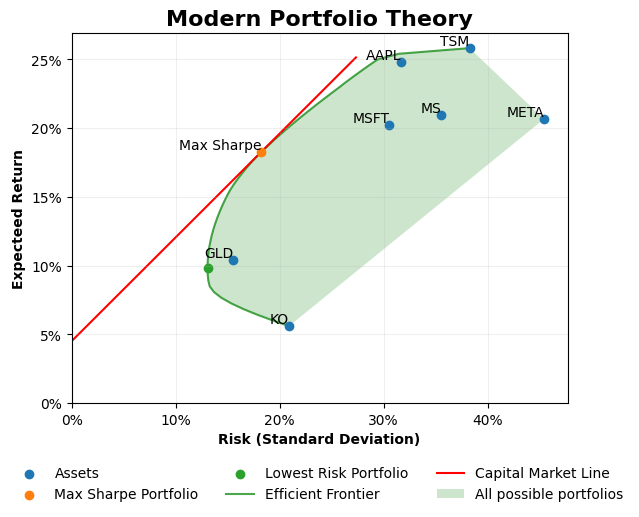

In [12]:
fig, ax = plt.subplots()

ax.scatter(np.sqrt(covariance_table.diagonal()) * np.sqrt(DAYS),
           mean_returns * DAYS,
           label="Assets")

ax.scatter(create_portfolio(mean_returns,max_sharpe.x, covariance_table)[1] * np.sqrt(DAYS),
           create_portfolio(mean_returns,max_sharpe.x, covariance_table)[0] * DAYS,
           label="Max Sharpe Portfolio")

ax.scatter(create_portfolio(mean_returns,lowest_risk.x, covariance_table)[1] * np.sqrt(DAYS),
           create_portfolio(mean_returns,lowest_risk.x, covariance_table)[0] * DAYS,
           label="Lowest Risk Portfolio")

# ax.text(create_portfolio(mean_returns,lowest_risk.x, covariance_table)[1] * np.sqrt(DAYS),
        # create_portfolio(mean_returns,lowest_risk.x, covariance_table)[0] * DAYS, 
        # "Lowest Risk", 
        # fontdict=
            # {"horizontalalignment":"left", "verticalalignment":'top'})

ax.text(create_portfolio(mean_returns,max_sharpe.x, covariance_table)[1] * np.sqrt(DAYS),
        create_portfolio(mean_returns,max_sharpe.x, covariance_table)[0] * DAYS, 
        "Max Sharpe", 
        fontdict=
            {"horizontalalignment":"right", "verticalalignment":'bottom'})

ax.plot(np.array(risk_min_list) * np.sqrt(DAYS), target_returns * DAYS, "green", alpha=0.7, zorder=0, label="Efficient Frontier")
ax.plot(capital_market_line_x, capital_market_line_y, "r", zorder=0, label="Capital Market Line")

ax.set_xlabel('Risk (Standard Deviation)', fontweight="bold")
ax.set_ylabel('Expecteed Return', fontweight="bold")

ax.set_ylim(0)
ax.set_xlim(0)

for i, t in enumerate(log_returns.columns):
    ax.text((np.sqrt(covariance_table.diagonal()))[i] * np.sqrt(DAYS),
            mean_returns[i] * DAYS,
            t,
        horizontalalignment='right',
        verticalalignment='bottom')

risk_min_arr = np.array(risk_min_list) * np.sqrt(DAYS)
cov_diag_arr = np.sqrt(np.diag(covariance_table)) * np.sqrt(DAYS)
target_returns_arr = np.array(target_returns) * DAYS
mean_returns_arr = np.array(mean_returns) * DAYS

points = np.column_stack([
    np.append(risk_min_arr, cov_diag_arr),
    np.append(target_returns_arr, mean_returns_arr)
])

hull = si.spatial.ConvexHull(points) 
hull_points = points[hull.vertices]


# for simplex in hull.simplices:
    # ax.plot(points[simplex, 0], points[simplex, 1], 'r-', linewidth=1, zorder=0)

ax.fill(hull_points[:, 0], hull_points[:, 1], 'g', alpha=0.2, zorder=0, label="All possible portfolios")

ax.legend( 
    loc="lower center",
    bbox_to_anchor=(0.5, -0.3),
    ncol=3,                   
    frameon=False)

ax.xaxis.set_major_formatter(PercentFormatter(1, 0))
ax.yaxis.set_major_formatter(PercentFormatter(1, 0))

ax.grid(True, zorder=0, alpha=0.2)

ax.set_title("Modern Portfolio Theory", fontweight="bold", fontsize=16)
# ax.

# ax.tight_layout()

# Portfolio Weights

In [13]:
sharpe_weights = {x: round(y,4) for x,y in zip(log_returns.columns, max_sharpe.x)}
sharpe_weights = sorted(sharpe_weights.items(), key=lambda x: x[1], reverse=True)

for ticker, weight in sharpe_weights:
    print(f"{ticker: <5} : {weight:.2%}")

GLD   : 43.77%
AAPL  : 31.33%
TSM   : 14.80%
MS    : 10.10%
KO    : 0.00%
META  : 0.00%
MSFT  : 0.00%


In [14]:
low_risk_weights = {x: round(y,4) for x,y in zip(log_returns.columns, lowest_risk.x)}
low_risk_weights = sorted(low_risk_weights.items(), key=lambda x: x[1], reverse=True)

for ticker, weight in low_risk_weights:
    print(f"{ticker: <5} : {weight:.2%}")

GLD   : 64.23%
KO    : 29.27%
TSM   : 2.11%
MS    : 1.45%
META  : 1.26%
AAPL  : 0.89%
MSFT  : 0.79%
